* Get VGG19
* Replace Max pooling with Average pooling
* Define Content loss as L2 distance between content image and X
* Define Style loss at some layer as L2 distance between Gram matrices
* Define full Style loss as weighted sum of s-losses in layers
* Define full loss as weighted sum of c- and s-losses

In [1]:
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F

from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL.Image
import collections

%matplotlib inline

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

img_transform = transforms.Compose([
    transforms.Scale(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def revert_normalize(img, mean=mean, std=std):
    res = img.copy()
    for c in range(3):
        res[c, :, :] = res[c, :, :] * std[c] + mean[c]
    res = res.clip(min=0, max=1)
    return res

def show_img(img, rescale=False):
    a = 0
    if rescale:
        a = (img - np.min(img)) / (np.max(img) - np.min(img))
    else:
        a = revert_normalize(img)
    a = np.rollaxis(a, 0, 3)
    a = np.uint8(np.clip(a, 0, 1)*255)
    
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, 'jpeg')
    display(Image(data=f.getvalue()))

In [3]:
vgg19 = models.vgg19(pretrained=True)

In [4]:
# replace MaxPool with AvgPool
def maybe_replace(node):
    if not isinstance(node, nn.MaxPool2d):
        return node
    ks = node.kernel_size + (node.kernel_size - 1) * node.dilation
    return nn.AvgPool2d(kernel_size=ks, stride=node.stride)

vgg19.features = nn.Sequential(*(maybe_replace(n) for n in vgg19.features))

In [5]:
class CustomVGG:
    def __init__(self, model):
        self.model = model
        
    def forward(self, x, end_layer):
        for i in range(end_layer):
            x = self.model.features[i](x)
        return x
    
    def multi_forward(self, x, layers):
        results = []
        for layer in layers:
            results.append(self.forward(x, layer))
        return results

    def cuda(self):
        self.model.cuda()

model = CustomVGG(vgg19)

In [6]:
vgg19.features

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): AvgPool2d (size=3, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): AvgPool2d (size=3, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU (inplace)
  (18): AvgPool2d (size=3, stride

Content image:


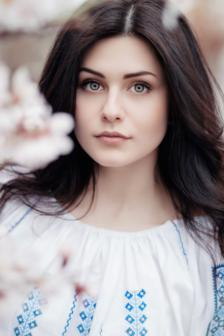

Style image:


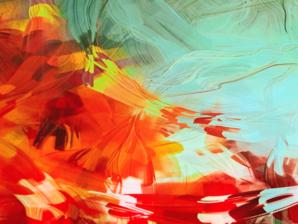

In [332]:
C_IMG = PIL.Image.open('img/girl1.jpg')
C_TENSOR = img_transform(C_IMG).unsqueeze(0)
C_NP = C_TENSOR.numpy()

S_IMG = PIL.Image.open('img/artwork.jpeg')
S_TENSOR = img_transform(S_IMG).unsqueeze(0)
S_NP = S_TENSOR.numpy()

print('Content image:')
show_img(C_NP[0])
print('Style image:')
show_img(S_NP[0])

In [258]:
## Laplacian Pyramid Gradient Normalization
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)
k5x5 = np.rollaxis(k5x5, 3)
k5x5 = np.rollaxis(k5x5, 3)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    h_o_p = int((img.shape[2] + 1) % 2)
    w_o_p = int((img.shape[3] + 1) % 2)
    pads = (h_o_p, w_o_p)
    img_v = Variable(torch.from_numpy(img)).float()
    conv = nn.Conv2d(3, 3, kernel_size=5, stride=2)
    conv.bias.data.zero_()
    conv.weight.data.zero_()
    conv.weight.data += torch.from_numpy(k5x5)
    lo = conv(img_v)
    conv_t = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=2, output_padding=pads)
    conv_t.bias.data.zero_()
    conv_t.weight.data.zero_()
    conv_t.weight.data += torch.from_numpy(k5x5*4)
    lo2 = conv_t(lo)
    hi = img_v - lo2
    return lo.data.numpy(), hi.data.numpy(), pads

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    std = np.sqrt(np.mean(img ** 2))
    return img / (std + eps)

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    pads = []
    for i in range(n):
        img, hi, pd = lap_split(img)
        levels.append(hi)
        pads.append(pd)
    levels.append(img)
    levels = list(map(normalize_std, levels))
    return levels[::-1], pads[::-1]

def lap_merge(levels, pads):
    '''Merge Laplacian pyramid'''
    img = Variable(torch.from_numpy(levels[0]))
    conv_t = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=2)
    conv_t.bias.data.zero_()
    conv_t.weight.data.zero_()
    conv_t.weight.data += torch.from_numpy(k5x5*4)
    for hi, pd in zip(levels[1:], pads):
        conv_t.output_padding = pd
        img = conv_t(img) + Variable(torch.from_numpy(hi))
    return img

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    tlevels, pads = lap_split_n(img, scale_n)
#     tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels, pads)
    return out.data.numpy()

In [341]:
def l2dist(x1, x2):
    return torch.mean((x1 - x2) ** 2)

def gram(x):
    channels = x.size(1)
    x = x.view(channels, -1)
    x = torch.mm(x, torch.t(x)) / x.size(1)
    return x

def transfer_style(model, num_iter=500, show_every=20,
                   lr=0.1, style_amplifier=1.0, content_amplifier=1.0,
                   C_LAYER=20):
    model.cuda()
    X_NP = np.random.randn(*C_NP.shape)*0.1+0.4
    
    S_VAR = Variable(torch.from_numpy(S_NP), requires_grad=False).float().cuda()
    S_FEATURES = model.multi_forward(S_VAR, [x[0] for x in S_LAYERS])
    S_GRAMS = [gram(f) for f in S_FEATURES]
    
    for it in range(num_iter):
        if it % show_every == 0:
            print('Iter', it)
            show_img(X_NP[0])
            
        # jitter
        sz = 32
        sx, sy = np.random.randint(sz, size=2)
        C_NP_SHIFT = np.roll(np.roll(C_NP, sx, 3), sy, 2)
        X_NP_SHIFT = np.roll(np.roll(X_NP, sx, 3), sy, 2)
        
        C_VAR = Variable(torch.from_numpy(C_NP_SHIFT), requires_grad=False).float().cuda()
        X_VAR = Variable(torch.from_numpy(X_NP_SHIFT), requires_grad=True).float().cuda()
        
        # scale
        scale_factor = np.random.rand(1)[0]*0.2 + 0.9
        h = int(X_NP.shape[-2] * scale_factor)
        w = int(X_NP.shape[-1] * scale_factor)
        C_VAR = nn.Upsample(size=(h, w), mode='bilinear')(C_VAR)
        X_VAR = nn.Upsample(size=(h, w), mode='bilinear')(X_VAR)
        
        C_FEATURES = model.forward(C_VAR, C_LAYER)
        X_C_FEATURES = model.forward(X_VAR, C_LAYER)
        C_LOSS = l2dist(X_C_FEATURES, C_FEATURES)
        
        X_S_FEATURES = model.multi_forward(X_VAR, [x[0] for x in S_LAYERS])
        X_S_GRAMS = [gram(f) for f in X_S_FEATURES]
        S_LOSSES = [l2dist(g1, g2) for g1, g2 in zip(X_S_GRAMS, S_GRAMS)]
        S_LOSS = 0
        for i in range(len(S_LOSSES)):
            S_LOSS += S_LOSSES[i] * S_LAYERS[i][1]
        
        LOSS = 0
        LOSS += C_LOSS * content_amplifier
        LOSS += S_LOSS * style_amplifier
        
        grad = torch.autograd.grad(LOSS, X_VAR)[0]
        
        # unscale
        h = int(X_NP.shape[-2])
        w = int(X_NP.shape[-1])
        grad = nn.Upsample(size=(h, w), mode='bilinear')(grad)
        grad = grad.data.cpu().numpy()
        
        # unjitter
        grad = np.roll(np.roll(grad, -sx, 3), -sy, 2)
        
        # TODO: LAPNORM
        grad = lap_normalize(grad)
        grad /= np.std(grad) + 1e-4
        
        X_NP -= grad * lr

In [342]:
S_LAYERS = (
#     (1, 1.0),
#     (3, 1.0),
    (6, 1.0),
    (8, 1.0),
    (11, 1.0),
    (13, 1.0),
#     (15, 1.0),
#     (17, 1.0),
)

Iter 0


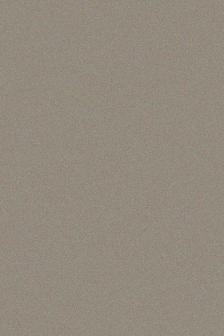

Iter 20


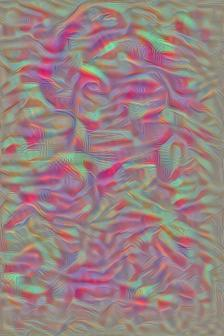

Iter 40


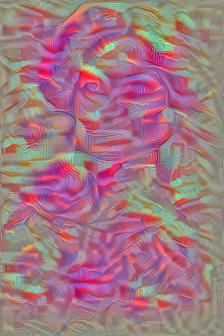

Iter 60


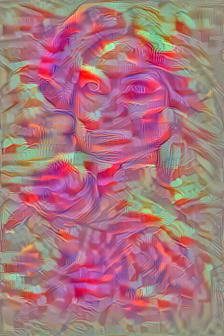

Iter 80


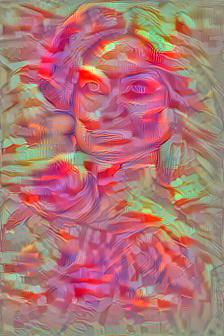

Iter 100


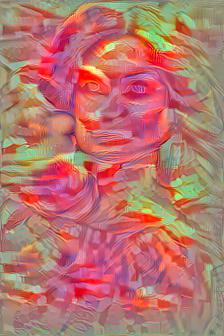

Iter 120


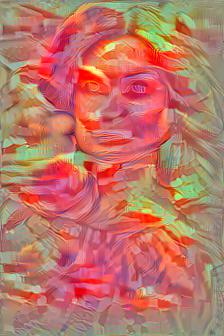

Iter 140


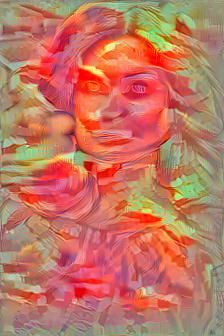

Iter 160


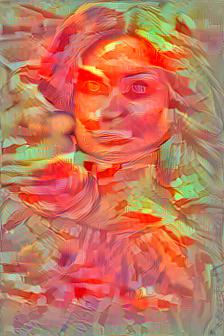

Iter 180


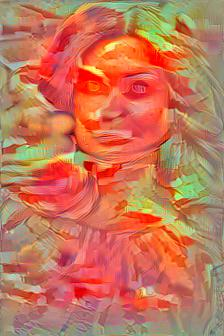

Iter 200


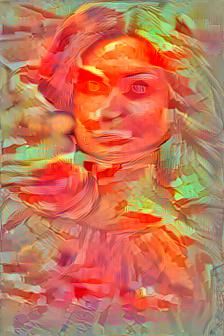

Iter 220


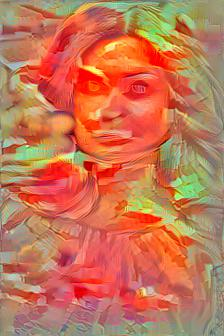

Iter 240


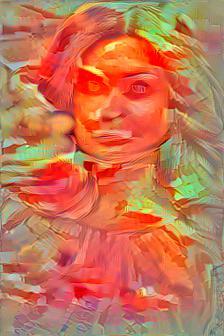

Iter 260


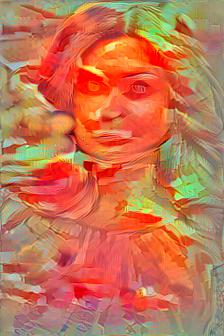

Iter 280


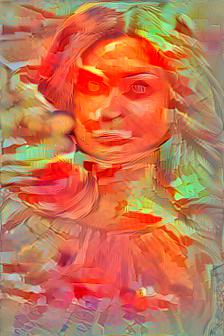

Iter 300


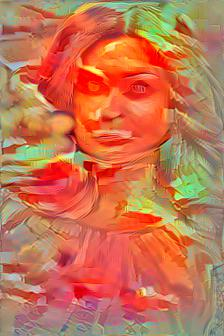

Iter 320


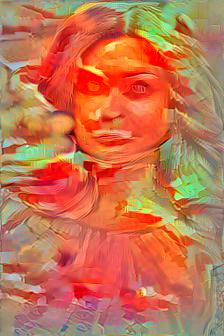

Iter 340


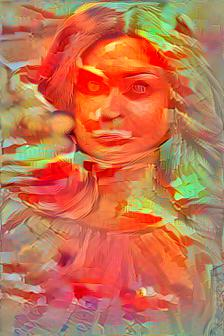

Iter 360


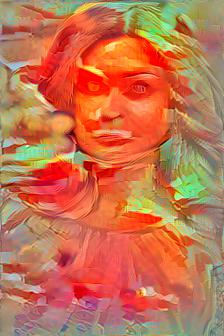

Iter 380


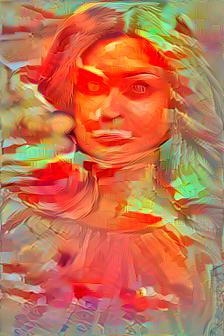

Iter 400


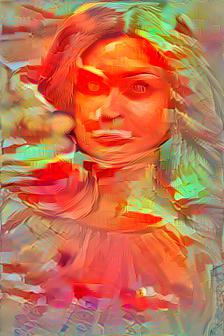

Iter 420


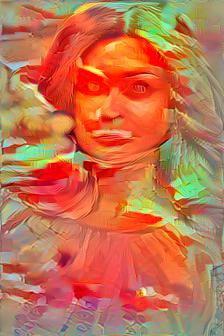

Iter 440


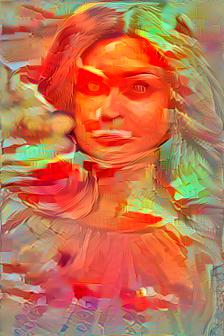

Iter 460


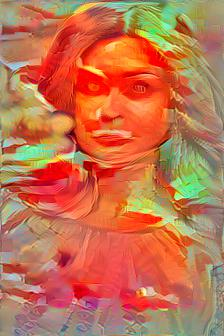

Iter 480


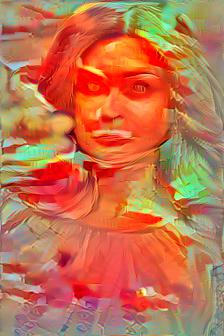

Iter 500


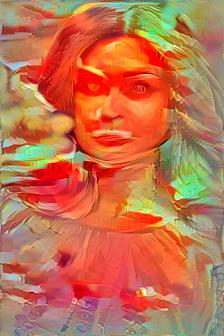

Iter 520


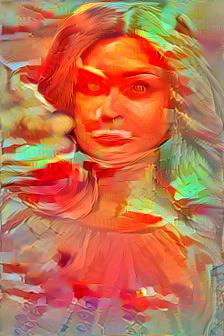

Iter 540


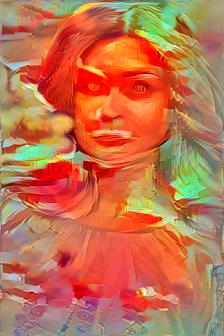

Iter 560


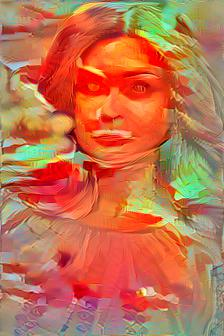

Iter 580


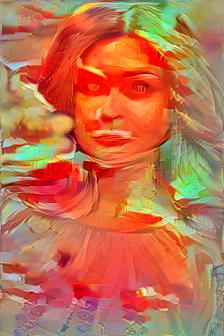

KeyboardInterrupt: 

In [347]:
transfer_style(model, lr=0.03, style_amplifier=0.5, content_amplifier=0.1, num_iter=1001, C_LAYER=17)